In [2]:
import zipfile
import tensorflow as tf
import os

os.environ["CUDA_VISIBLE_DEVICES"]="0"
with tf.device('/gpu:0'):
    a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')
    b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b')
    c = tf.matmul(a, b)
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)
print (session.run(c))

[[22. 28.]
 [49. 64.]]


In [3]:
from keras.models import *
from keras.callbacks import *
from keras.layers import *
from keras.layers.core import *
from keras import backend as K
from keras.optimizers import *
from keras.losses import *
from keras.preprocessing.image import ImageDataGenerator
from skimage import io, transform
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [4]:
def define_block(input_layer, nb_layers, nb_neurons, kernel_size=(3,3), batch_normalization=True, activation='relu', **kwargs):
    index = None
    if 'index' in kwargs:
        index = kwargs['index']
    
    for i in range(nb_layers):
        if i == 0:
            b = input_layer

        b = Conv2D(nb_neurons, kernel_size=kernel_size, strides=1, padding='same', name='conv' + str(i) + '_block' + str(index))(b)
        if batch_normalization:
            b = BatchNormalization(name='batchnorm' + str(i) + '_block' + str(index))(b)
        b =  Activation(activation, name=activation + str(i) + '_block' + str(index))(b)
    b = MaxPooling2D(pool_size=(2,2), name='maxpooling_block' + str(index))(b)
    return b

def define_skipped_connection(src_layer, dst_layer):
    src_shape = src_layer.output_shape
    dst_shape = dst_layer.input_shape
    

def SkippedVGG(nb_blocks, input_shape, num_classes, nb_layers, nb_neurons, include_top=True, verbose=1):
    concats = []
    for i in range(nb_blocks):
        concats.append([])
        
    if type(nb_layers) is int:
        temp = nb_layers
        nb_layers = []
        for i in range(nb_blocks):
            nb_layers.append(temp)
    
    if verbose:
        print('Create DensedVGG model with ' + str(nb_blocks) + ' blocks, input shape = ' + str(input_shape))
    
    for i in range(nb_blocks):
        if verbose:
            print('Create block ' + str(i) + ':')
        
        if i == 0: # First block
            b = Input(shape=input_shape)
            inputs = b
        
        # check all layers before
        if len(concats[i-1]) > 1:
            if verbose:
                print('Concatenate ', concats[i-1])
            b = concatenate(concats[i-1])
        elif len(concats[i-1]) == 1:
            if verbose:
                print('Get direct output from the previous block ', concats[i-1])
            b = concats[i-1][0]
            
        # create main block
        b = define_block(b, nb_layers[i], nb_neurons[i], index=i)
        concats[i].append(b)
        
        # create cropping layer
        for j in range(i+1, nb_blocks):
            if verbose:
                print('-- create skipped connection from block '+ str(i) + ' to block ' + str(j+1) + ' ...')
                
            src_shape = b.get_shape()
            src_shape = (int(src_shape[1]), int(src_shape[2]), int(src_shape[3]))
            dst_shape = (src_shape[0]//2**(j-i), src_shape[1]//2**(j-i), src_shape[2])
            
            print(src_shape, dst_shape)
            h = src_shape[0] - dst_shape[0]
            w = src_shape[1] - dst_shape[1]
            if h % 2 == 0:
                h_0 = h // 2
                h_1 = h // 2
            else:
                h_0 = h // 2
                h_1 = (h // 2) + 1
            
            if w % 2 == 0:
                w_0 = w // 2
                w_1 = w // 2
            else:
                w_0 = w // 2
                w_1 = (w // 2) + 1
                
            concat_layer = Cropping2D(((h_0,h_1),(w_0,w_1)), name='cropping_block' + str(i) + '_block' + str(j+1))(b)
            concats[j].append(concat_layer)
            
    # top model
    if verbose:
        print('Create top model')
        
    if len(concats[nb_blocks-1]) == 1:
        outputs = concats[nb_blocks-1]
    else:
        outputs = concatenate(concats[nb_blocks-1])
    
    outputs = GlobalAveragePooling2D()(outputs)
    outputs = Dense(num_classes)(outputs)
    outputs = BatchNormalization()(outputs)
    outputs = Activation('softmax')(outputs)

    model = Model(inputs=inputs, outputs=outputs)
    
    # compile
    model.compile(loss=categorical_crossentropy, optimizer=Adam(), metrics=['accuracy'])
    
    if verbose:
        model.summary()
    return model


def SkippedVGG_2(nb_blocks, input_shape, num_classes, nb_layers, nb_neurons, include_top=True, verbose=1):
    concats = []
    for i in range(nb_blocks):
        concats.append([])
        
    if type(nb_layers) is int:
        temp = nb_layers
        nb_layers = []
        for i in range(nb_blocks):
            nb_layers.append(temp)
    
    if verbose:
        print('Create DensedVGG model with ' + str(nb_blocks) + ' blocks, input shape = ' + str(input_shape))
    
    for i in range(nb_blocks):
        if verbose:
            print('Create block ' + str(i) + ':')
        
        if i == 0: # First block
            b = Input(shape=input_shape)
            inputs = b
        
        # check all layers before
        if len(concats[i-1]) > 1:
            if verbose:
                print('Concatenate ', concats[i-1])
            b = concatenate(concats[i-1])
        elif len(concats[i-1]) == 1:
            if verbose:
                print('Get direct output from the previous block ', concats[i-1])
            b = concats[i-1][0]
            
        # create main block
        b = define_block(b, nb_layers[i], nb_neurons[i], index=i)
        concats[i].append(b)
        
        # create cropping layer
        for j in range(i+1, nb_blocks):
            if verbose:
                print('-- create skipped connection from block '+ str(i) + ' to block ' + str(j+1) + ' ...')
                
            src_shape = b.get_shape()
            src_shape = (int(src_shape[1]), int(src_shape[2]), int(src_shape[3]))
            dst_shape = (src_shape[0]//2**(j-i), src_shape[1]//2**(j-i), src_shape[2])
            
            print(src_shape, dst_shape)
            
            # Calculate the stride in a spatial average layer
            # if we fix the kernel size is 2
            avg_kernel_size = 2
            avg_stride_0 = int((src_shape[0] - avg_kernel_size)/(dst_shape[0] - 1))
            avg_stride_1 = int((src_shape[0] - avg_kernel_size)/(dst_shape[0] - 1))
            
            avg_layer = AveragePooling2D(pool_size=(avg_kernel_size, avg_kernel_size), 
                                         strides=(avg_stride_0, avg_stride_1), padding='valid',
                                        name='avgpooling_block' + str(i) + '_block' + str(j+1))(b)
            
            
            concats[j].append(avg_layer)
            del(avg_layer)
            
    # top model
    if verbose:
        print('Create top model')
        
    if len(concats[nb_blocks-1]) == 1:
        outputs = concats[nb_blocks-1]
    else:
        outputs = concatenate(concats[nb_blocks-1])
    
    outputs = GlobalAveragePooling2D()(outputs)
    outputs = Dense(num_classes)(outputs)
    outputs = BatchNormalization()(outputs)
    outputs = Activation('softmax')(outputs)

    model = Model(inputs=inputs, outputs=outputs)
    
    # compile
    model.compile(loss=categorical_crossentropy, optimizer=Adam(), metrics=['accuracy'])
    
    if verbose:
        model.summary()
    return model
    

In [5]:
batch_size = 256
epochs = 100

train_datagen = ImageDataGenerator(rotation_range=360,
                                   rescale=1./255,
                                   fill_mode='nearest')
test_datagen = ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow_from_directory('/tf/data/Quan/fer2013/data/train', 
                                                    target_size=(48,48), 
                                                    batch_size=batch_size, 
                                                    color_mode = 'grayscale',
                                                    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory('/tf/data/Quan/fer2013/data/val',
                                                       target_size=(48,48), 
                                                       batch_size=batch_size, 
                                                        color_mode = 'grayscale',
                                                       class_mode='categorical')

test_generator = test_datagen.flow_from_directory('/tf/data/Quan/fer2013/data/test',
                                                 target_size=(48,48), 
                                                 batch_size=batch_size, 
                                                  color_mode = 'grayscale',
                                                 class_mode='categorical')

# predict_generator = test_datagen.flow_from_directory('drive/My Drive/test_data_vietnam_blue_2',
#                                                     target_size=(144,192),
#                                                     batch_size=1,
#                                                     class_mode=None,
#                                                     shuffle=False)

Found 28709 images belonging to 7 classes.
Found 3589 images belonging to 7 classes.
Found 3589 images belonging to 7 classes.


In [6]:
label_dict = train_generator.class_indices
label_dict = {k:v for v,k in label_dict.items()}
label_dict

{0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6'}

In [7]:
model = SkippedVGG_2(nb_blocks=3, input_shape=(48,48,1), num_classes=7, nb_layers=2, nb_neurons=[64,128,256], include_top=True, verbose=1)

Create DensedVGG model with 3 blocks, input shape = (48, 48, 1)
Create block 0:
Instructions for updating:
If using Keras pass *_constraint arguments to layers.

-- create skipped connection from block 0 to block 2 ...
(24, 24, 64) (12, 12, 64)

-- create skipped connection from block 0 to block 3 ...
(24, 24, 64) (6, 6, 64)
Create block 1:
Get direct output from the previous block  [<tf.Tensor 'maxpooling_block0/MaxPool:0' shape=(?, 24, 24, 64) dtype=float32>]
-- create skipped connection from block 1 to block 3 ...
(12, 12, 128) (6, 6, 128)
Create block 2:
Concatenate  [<tf.Tensor 'avgpooling_block0_block2/AvgPool:0' shape=(?, 12, 12, 64) dtype=float32>, <tf.Tensor 'maxpooling_block1/MaxPool:0' shape=(?, 12, 12, 128) dtype=float32>]
Create top model
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)   

In [ ]:
'''Training'''

mcp = ModelCheckpoint('/tf/data/Quan/fer2013/skippedvgg_keras.hdf5', monitor='val_acc', save_best_only=True, save_weights_only=False)
history = model.fit_generator(train_generator, steps_per_epoch=28709//batch_size, epochs=epochs, verbose=1, validation_data=validation_generator, validation_steps=3589//batch_size, callbacks=[mcp])


Epoch 1/100
112/112 [==============================] - 14s 126ms/step - loss: 1.9137 - accuracy: 0.2257 - val_loss: 2.0649 - val_accuracy: 0.1694
Epoch 2/100
  1/112 [..............................] - ETA: 10s - loss: 1.8478 - accuracy: 0.2773

/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


112/112 [==============================] - 11s 99ms/step - loss: 1.8409 - accuracy: 0.2653 - val_loss: 2.1927 - val_accuracy: 0.1665
Epoch 3/100
112/112 [==============================] - 11s 99ms/step - loss: 1.7936 - accuracy: 0.2954 - val_loss: 2.4856 - val_accuracy: 0.1716
Epoch 4/100
112/112 [==============================] - 11s 100ms/step - loss: 1.6910 - accuracy: 0.3511 - val_loss: 2.4718 - val_accuracy: 0.1902
Epoch 5/100
112/112 [==============================] - 11s 100ms/step - loss: 1.5833 - accuracy: 0.4031 - val_loss: 1.6831 - val_accuracy: 0.3375
Epoch 6/100
112/112 [==============================] - 11s 99ms/step - loss: 1.4920 - accuracy: 0.4394 - val_loss: 1.7689 - val_accuracy: 0.3336
Epoch 7/100
112/112 [==============================] - 11s 99ms/step - loss: 1.4248 - accuracy: 0.4661 - val_loss: 1.3637 - val_accuracy: 0.4296
Epoch 8/100
112/112 [==============================] - 11s 100ms/step - loss: 1.3890 - accuracy: 0.4781 - val_loss: 1.6505 - val_accuracy: 0

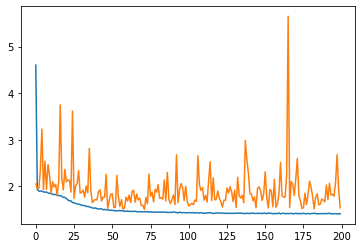

In [38]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

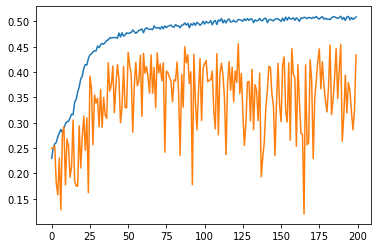

In [39]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])